In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds, engine='netcdf4')

In [3]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

# Vertical velocity 

In [4]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

In [5]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
from cmcrameri import cm

In [15]:
exp['curr'].w.sel(inidate='2023-10-17', time=timestep, level=500).mean('number').min().values

array(-3.4671116, dtype=float32)

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


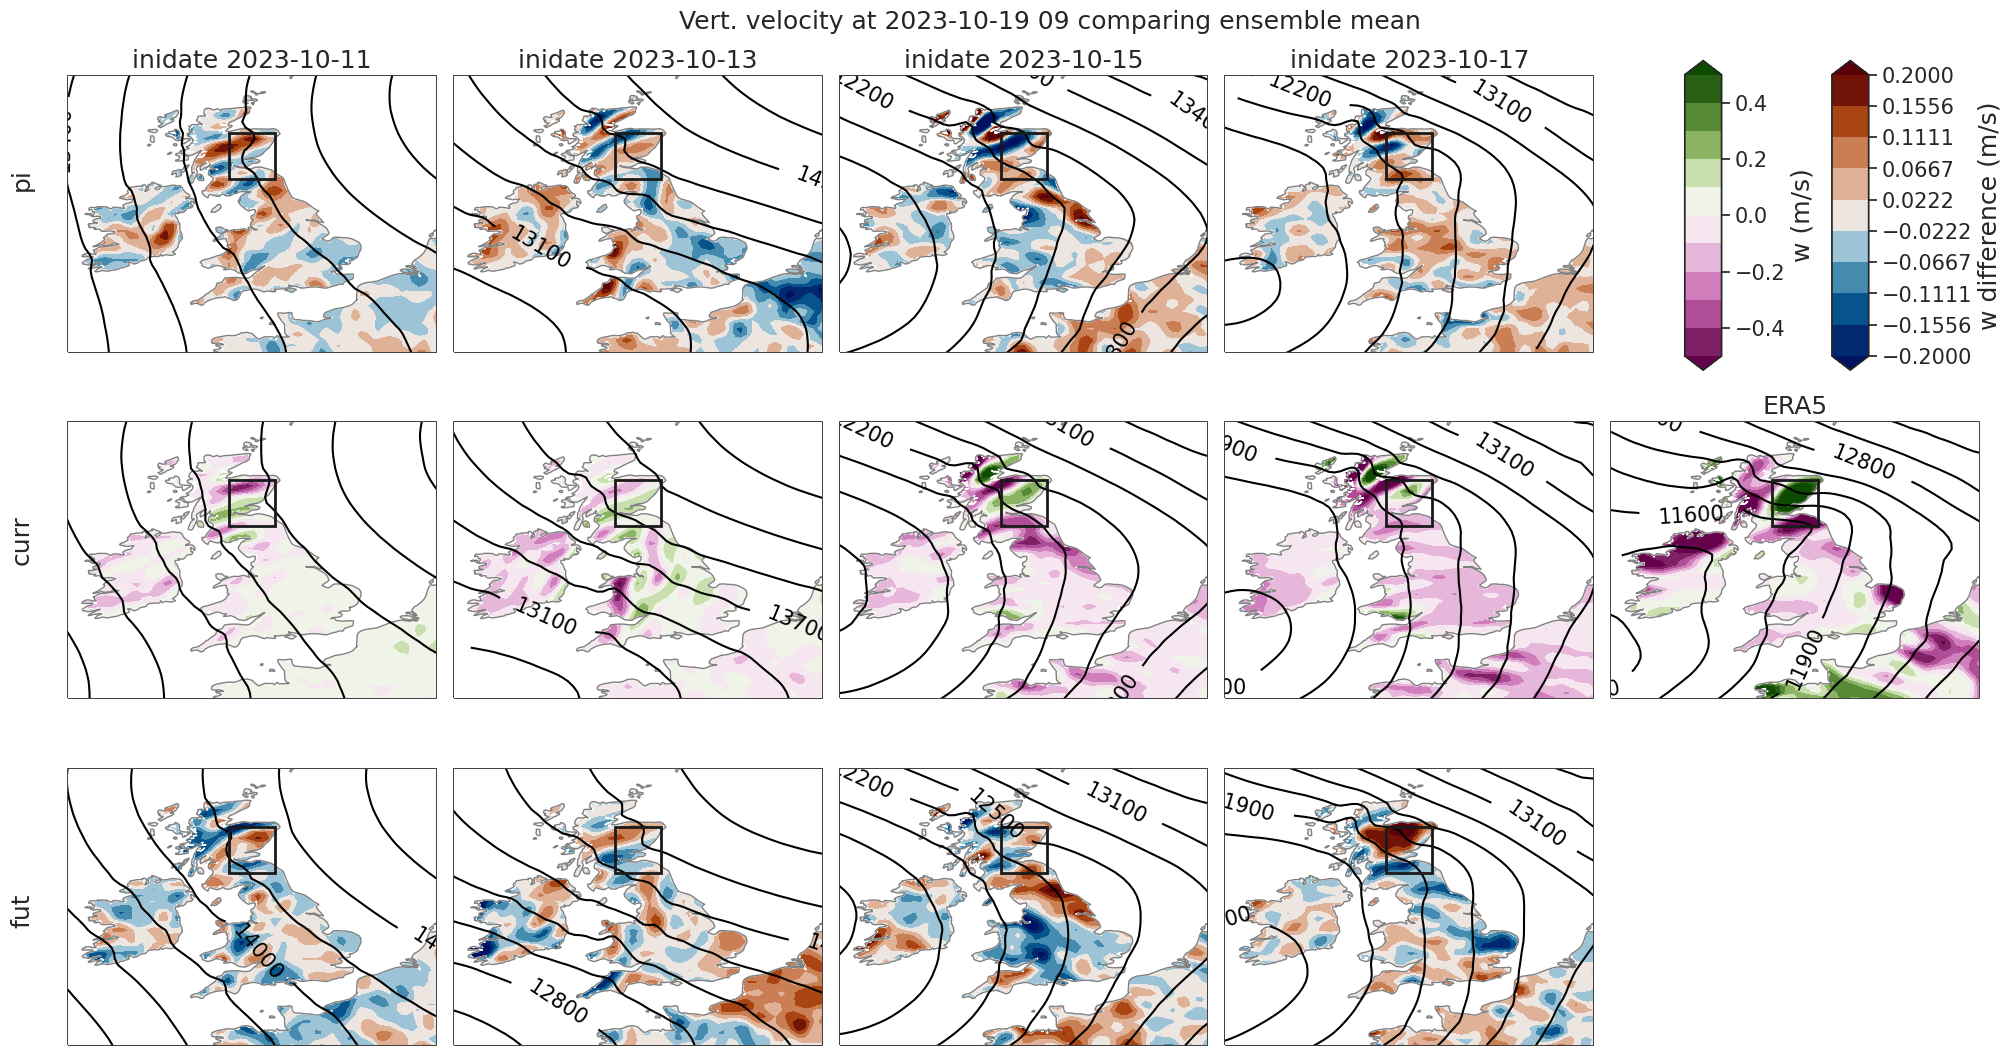

In [56]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 15000
p_min = 11000

w_min = -0.5
w_max = 0.5

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=850)).mean(dim='number').z.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            w_vals = (exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            w_vals = exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_w = np.linspace(w_min, w_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                            transform=projection, zorder = 10, extend = 'both')
        else: 
            clevs_w = np.linspace(-0.2, 0.2, 10)
            cf_diff = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.z.sel(time=timestep, level=850).values
w_vals = era5.w.sel(time=timestep, level=500).values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_w = np.linspace(w_min, w_max, 11)  # 17
cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 300)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black', # clevs_p,
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='w (m/s)', extend = 'max', shrink=0.8)
cbar.set_label(label='w (m/s)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='w difference (m/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='w difference (m/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Vert. velocity at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

plt.savefig('figures/08_w_{}.png'.format(timestep), dpi=600)
plt.savefig('figures/08_w_{}.pdf'.format(timestep))

# Upper level winds and relative humidity

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


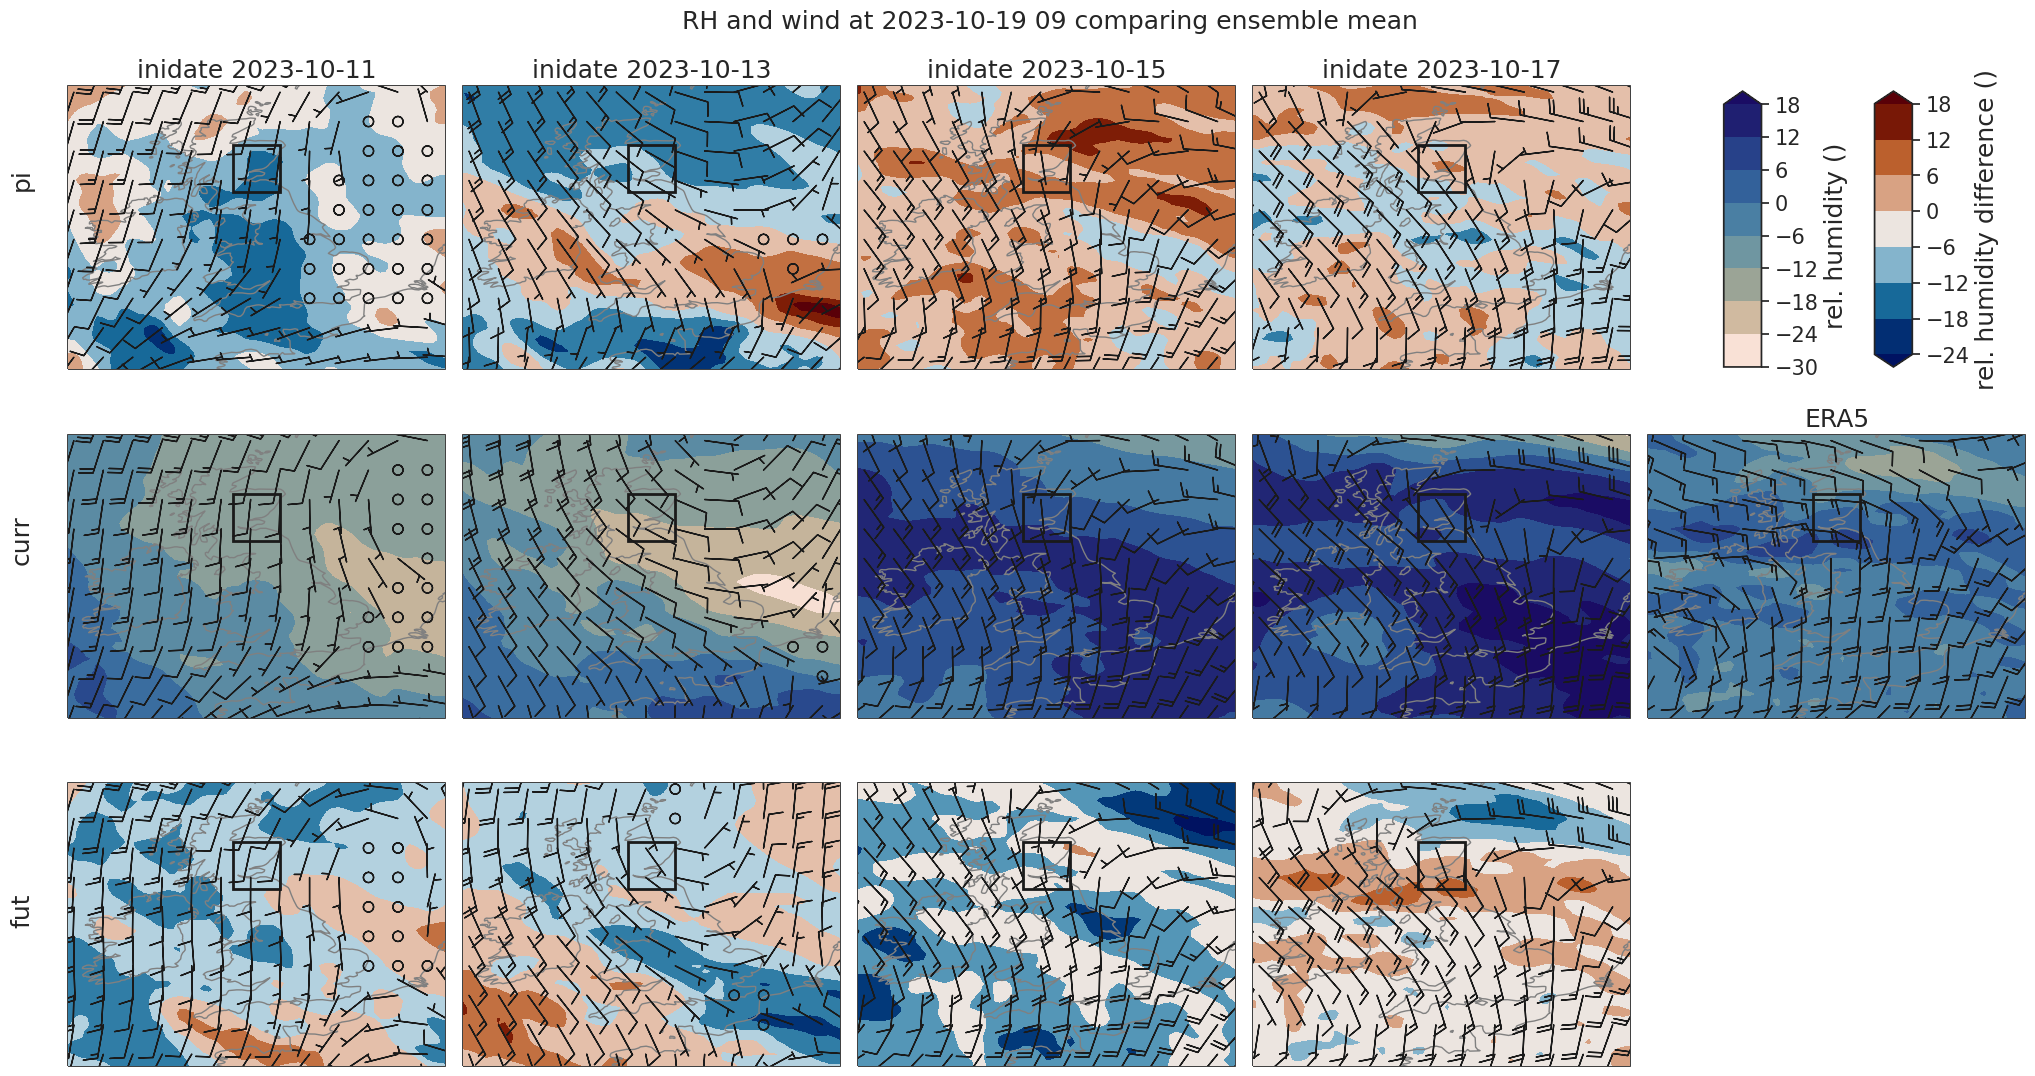

In [40]:
# figure and map setup
from matplotlib.pyplot import step


experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
u_max = 30
u_min = 0

r_min = 0
r_max = 0.001

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'
steps = 5

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values
# fewer grid points for wind barbs
thin_latitude = latitude[::steps]
thin_longitude = longitude[::steps]

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        u_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').u.values[::steps, ::steps]
        v_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').v.values[::steps, ::steps]

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            r_vals = (exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            r_vals = exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # humidity as shading
        if experiment =='curr':
            clevs_r = np.linspace(r_min, r_max, 11)
            cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.lapaz_r,
                            transform=projection, zorder = 13, extend = 'max')
        else: 
            clevs_r = np.linspace(-0.0005, 0.0005, 10)
            cf_diff = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.vik,
                                  transform=projection, zorder = 13, extend = 'both')
        
        # barbs for wind
        cs = ax.barbs(thin_longitude, thin_latitude, u_vals, v_vals, zorder = 16)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.z.sel(time=timestep, level=850).values
u_vals = era5.u.sel(time=timestep, level=500).values[::steps, ::steps]
v_vals = era5.v.sel(time=timestep, level=500).values[::steps, ::steps]

ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# RH as shading
clevs_r = np.linspace(r_min, r_max, 11)
cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.lapaz_r,
                transform=projection, zorder = 13, extend = 'max')

# wind as barbs
cs = ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='rel. humidity ()', extend = 'max', shrink=0.8)
cbar.set_label(label='rel. humidity ()', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='rel. humidity difference ()', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='rel. humidity difference ()', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('RH (500hPa) and wind (200hPa) at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

# Vertical velocity in time

In [49]:
inidate = '2023-10-17'
p_vals = (exp['pi'].sel(inidate=inidate, time=timestep, level=850)).mean(dim='number').z.values
# w_vals = (exp['pi'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
w_vals = exp['curr'].w.sel(inidate=inidate, level=500).mean('number').squeeze().values

howdy


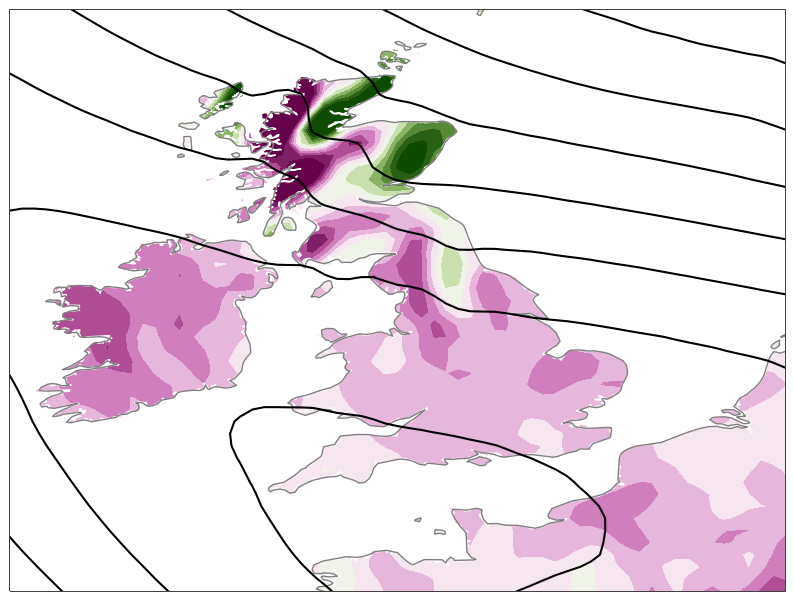

In [48]:
plt.figure(1, figsize=(10, 10)) 

w_min = -0.5
w_max = 0.5
p_min = 11000
p_max = 15000

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

clevs_p =np.arange(p_min, p_max, 300)
ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
           transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)

experiment = 'curr'
if experiment =='curr':
    clevs_w = np.linspace(w_min, w_max, 11)  # 17
    print('howdy')
    cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                    transform=projection, zorder = 10, extend = 'both')
else: 
    clevs_w = np.linspace(-0.2, 0.2, 10)
    cf_diff = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.vik,
                            transform=projection, zorder = 10, extend = 'both')

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


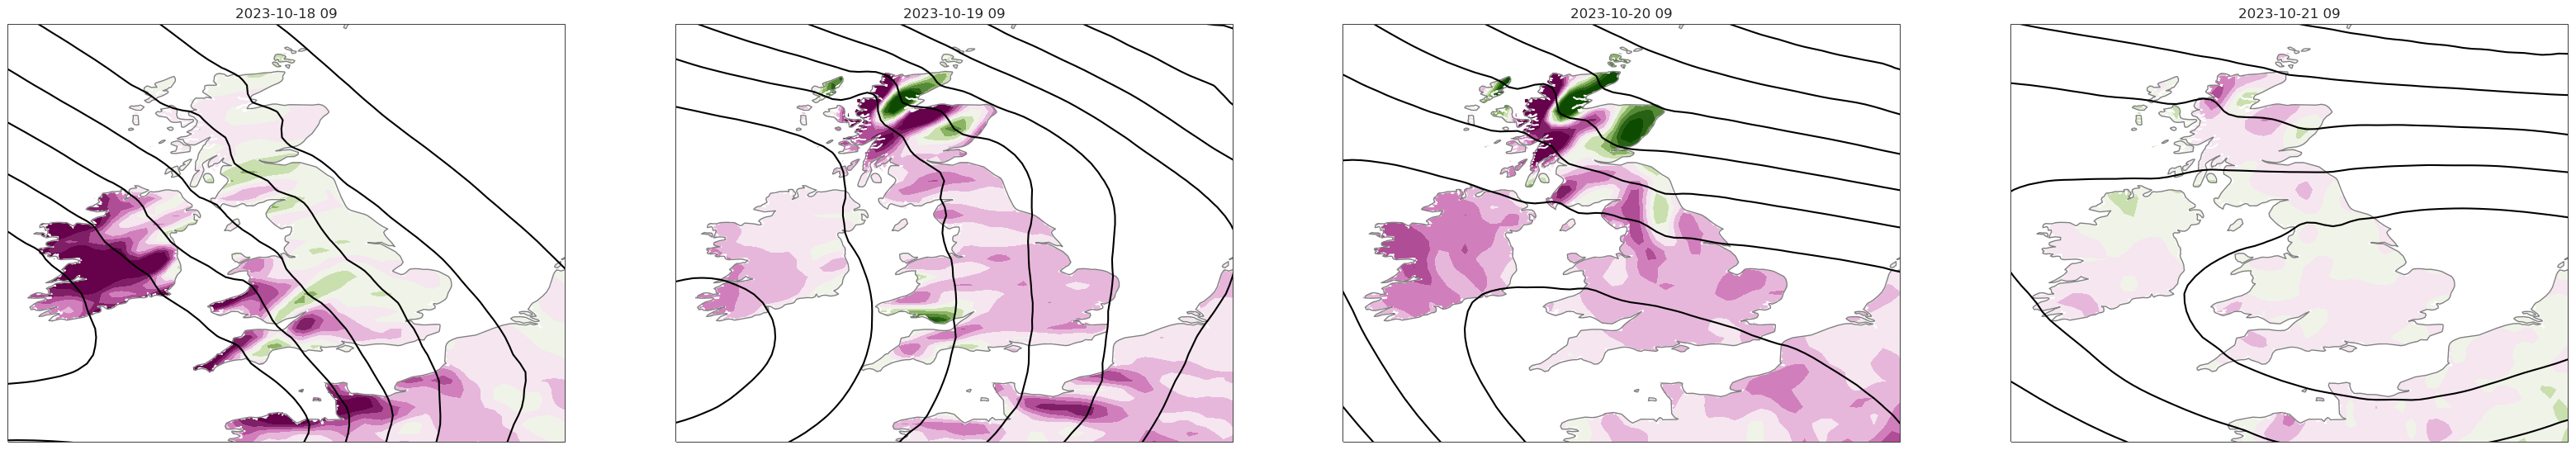

In [52]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(40, 10)) 

w_min = -0.5
w_max = 0.5
p_min = 11000
p_max = 15000

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        w_vals = exp['curr'].w.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        ax = plt.subplot(1,4,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        clevs_p =np.arange(p_min, p_max, 300)
        ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        clevs_w = np.linspace(w_min, w_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t)


/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


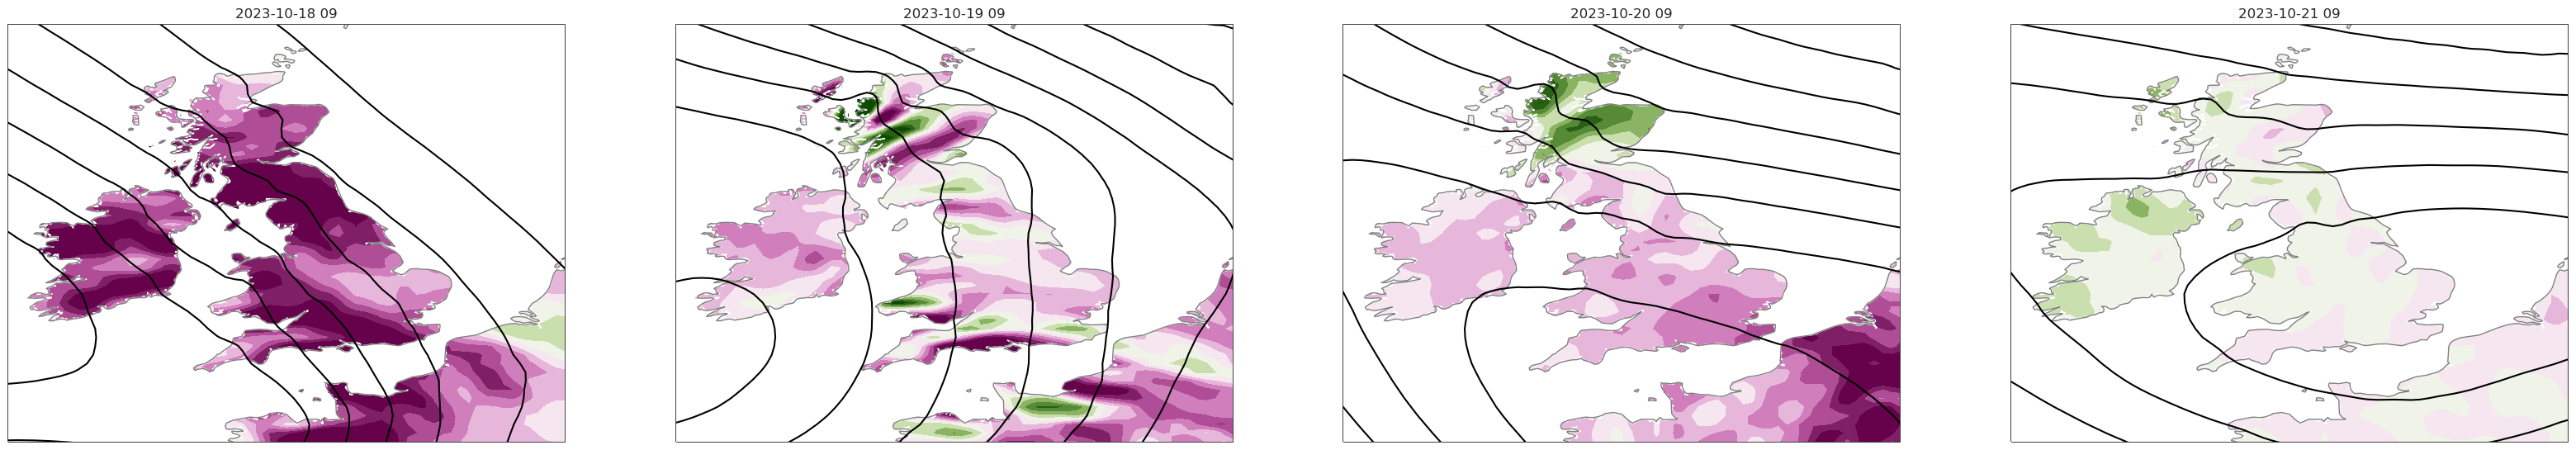

In [55]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(40, 10)) 

w_min = -0.05
w_max = 0.05
p_min = 11000
p_max = 15000

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        w_vals = exp['curr'].w.sel(inidate=inidate, time=t, level=200).mean('number').squeeze().values

        ax = plt.subplot(1,4,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        clevs_p =np.arange(p_min, p_max, 300)
        ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        clevs_w = np.linspace(w_min, w_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t)

# Relative humidity in time

In [64]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(40, 10)) 

r_min = 0
r_max = 100

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values
thin_latitude = latitude[::5]
thin_longitude = longitude[::5]

for i,t in enumerate(timesteps):
        u_vals = (exp['curr'].sel(inidate=inidate, time=t, level=200)).mean(dim='number').u.values[::5, ::5]
        v_vals = (exp['curr'].sel(inidate=inidate, time=t, level=200)).mean(dim='number').v.values[::5, ::5]
        r_vals = exp['curr'].r.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        ax = plt.subplot(1,4,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)

        clevs_r = np.linspace(r_min, r_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.glasgow,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t)

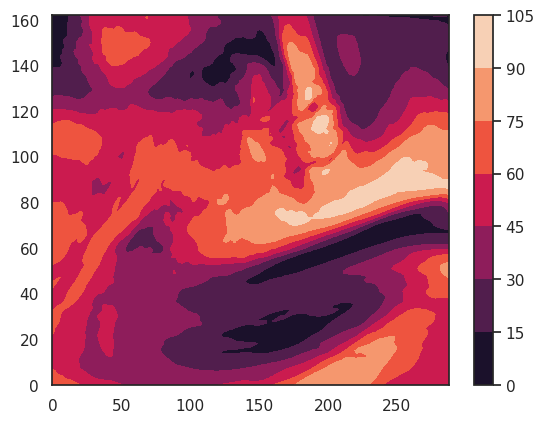

In [62]:
t = plt.contourf(r_vals)
plt.colorbar(t)